In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp
import itertools

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# get data through ONE, not DJ
from oneibl.one import ONE
one = ONE()

Connecting anneurai@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as anneu
Connected to https://alyx.internationalbrainlab.org as anneu


In [2]:
# get all ephysCW sessions
sess = acquisition.Session & 'task_protocol LIKE "%ephysChoiceWorld%"'
b = sess * behavior.TrialSet.Trial
b = b.proj('session_lab', 'task_protocol', 'trial_stim_prob_left')
df = b.fetch(format='frame').reset_index()

In [3]:
# count the number of trials in each sequence
def run_length(l):
    answer = []
    for key, iter in itertools.groupby(l):
        answer.append((key, len(list(iter))))
    return answer

block_lenghts = []
for name, group in df.groupby(['session_lab', 'task_protocol', 'session_start_time']):
    run_lengths = pd.DataFrame(run_length(group.trial_stim_prob_left))
    tmp_df = pd.DataFrame({'prob_left':run_lengths[0].values, 'length':run_lengths[1].values})
    tmp_df['session_lab'] = name[0]
    tmp_df['task_protocol'] = name[1]
    tmp_df['session_start_time'] = name[2]
    block_lenghts.append(tmp_df)
    

In [4]:
df2 = pd.concat(block_lenghts)

# abbreviate the task protocols
df2['task'] = df2['task_protocol'].str.replace('_iblrig_tasks_ephysChoiceWorld', 'ephysCW')
df2['task'] = df2.task.str[:-2]
sorted(df2.task.unique())

# also get one without the 0.5 blocks
# df3 = df2.loc[df2.prob_left != 0.5, :]

['ephysCW4.1',
 'ephysCW5.2',
 'ephysCW5.3',
 'ephysCW6.0',
 'ephysCW6.1',
 'ephysCW6.2',
 'ephysCW6.4']

Text(0.5, 0.98, 'All ephysCW probabilityLeft from DataJoint')

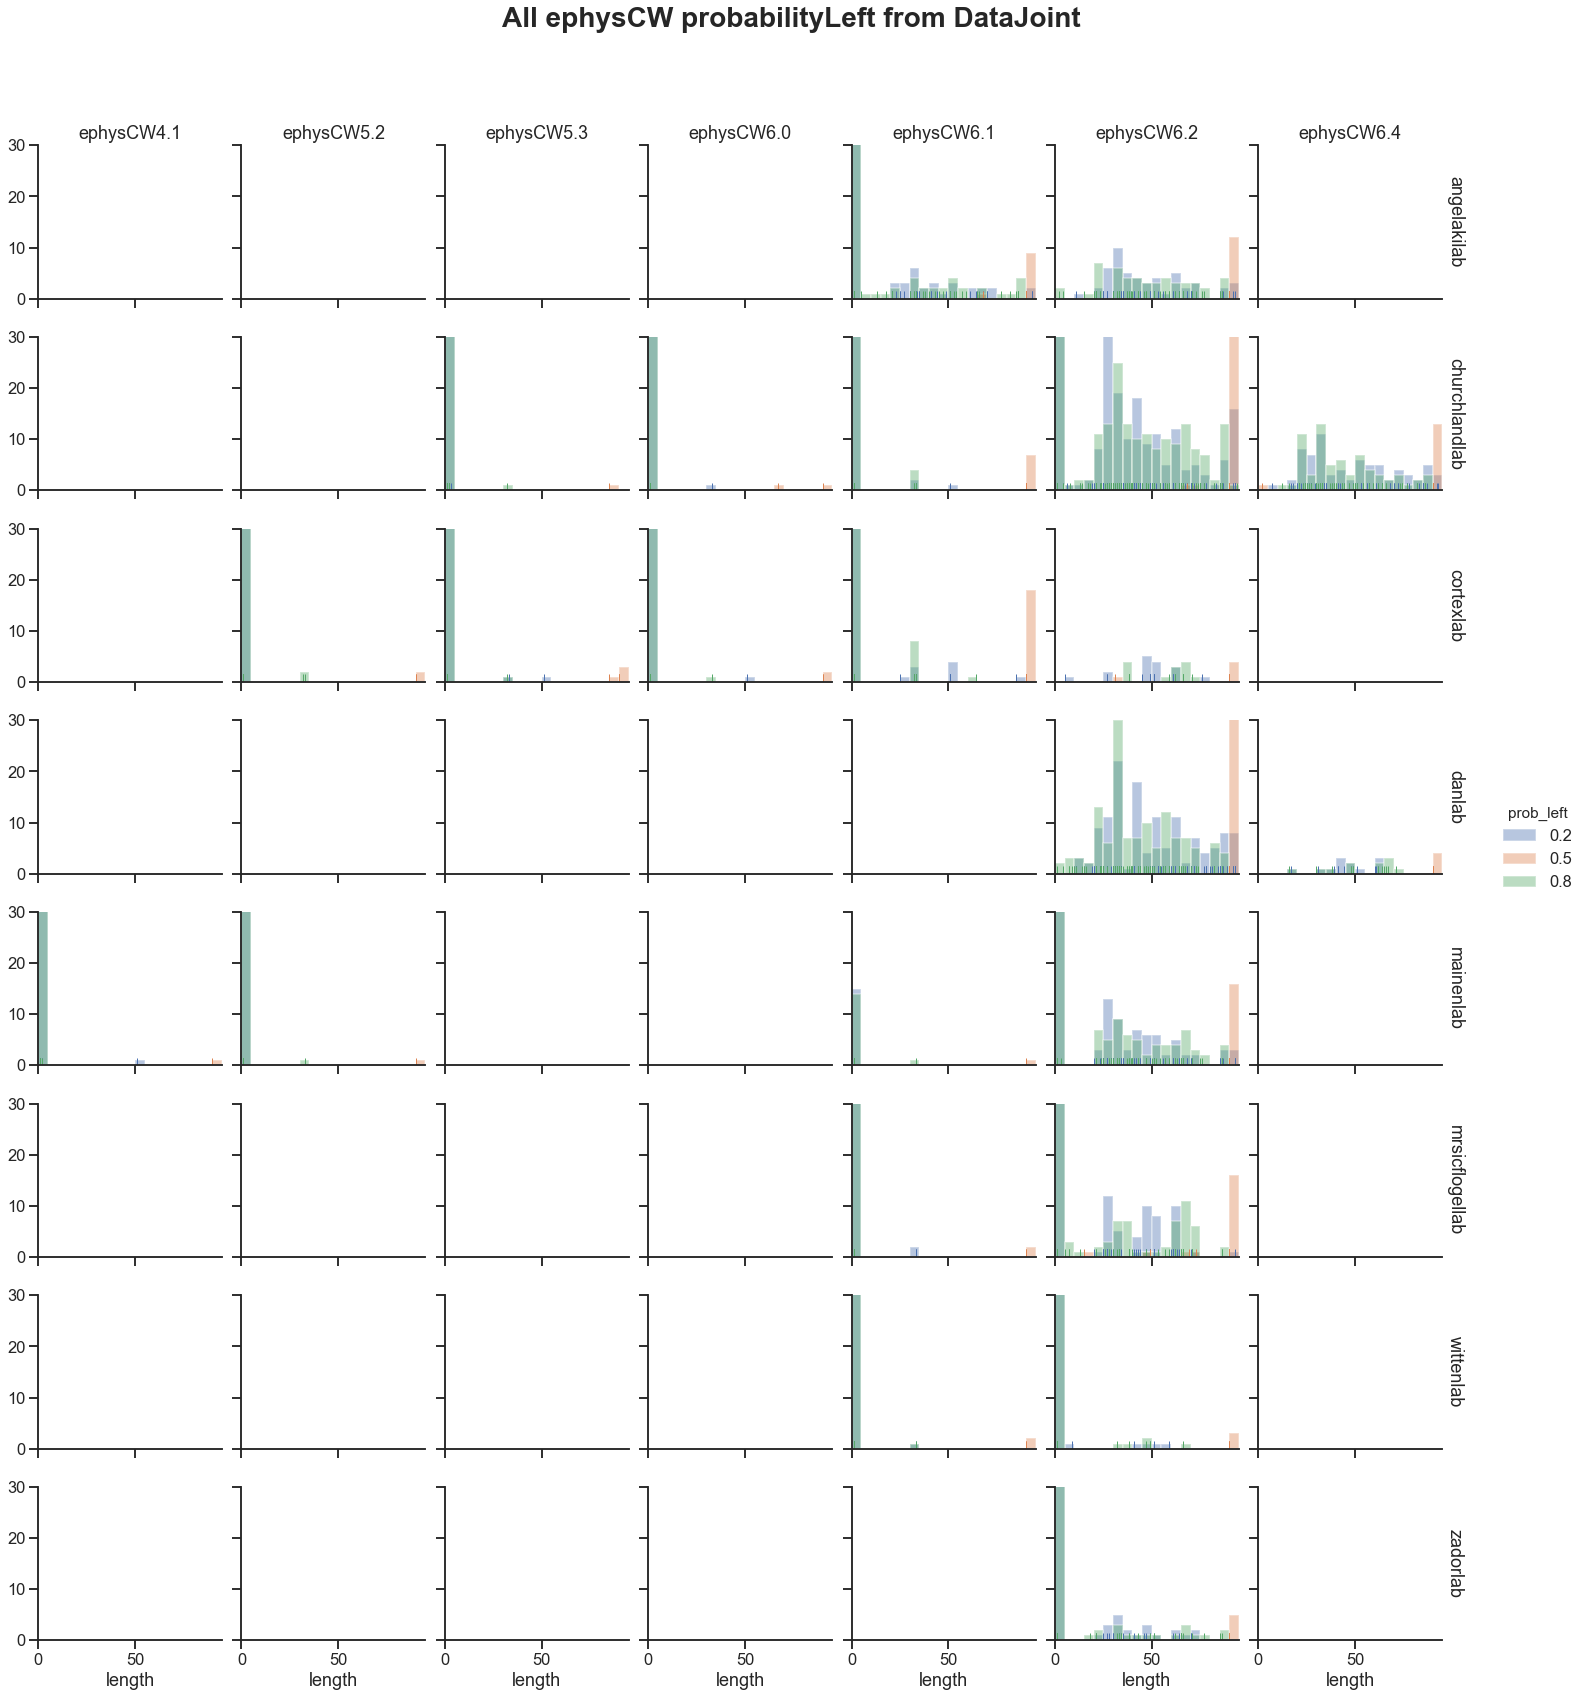

In [5]:
## make a big overview
g = sns.FacetGrid(df2, row="session_lab", col='task', 
                  col_order=sorted(df2.task.unique()), hue="prob_left", ylim=[0,30], xlim=[0,95], margin_titles=True)
g.map(sns.distplot, "length", rug=True, kde=False, hist=True, bins=np.arange(0, 100, 5)).add_legend()
[plt.setp(ax.texts, text="") for ax in g.axes.flat] # to clean margin titles on the right
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('All ephysCW probabilityLeft from DataJoint', fontsize=28, weight='bold')

## now redo with data from ONE

In [6]:
# get all ephysCW sessions
sessions = sess.proj('session_uuid', 'session_lab', 'task_protocol', 'session_start_time').fetch(format='frame').reset_index()
eids = [str(eid) for eid in sessions['session_uuid'].values]  # cast to strings
len(eids)

352

In [7]:
block_lenghts = []

for ex, eid in enumerate(eids):
    
    # print(eid)
    try:# get session details
        prob_left = one.load(eid, dataset_types='trials.probabilityLeft', keep_uuid=True, clobber=False)
        run_lengths = pd.DataFrame(run_length(prob_left[0]))

        # put in dict with session info
        tmp_df = pd.DataFrame({'prob_left':run_lengths[0].values, 'length':run_lengths[1].values})
    
        tmp_df['session_lab'] = sessions.iloc[ex].session_lab
        tmp_df['task_protocol'] = sessions.iloc[ex].task_protocol
        tmp_df['session_start_time'] = sessions.iloc[ex].session_start_time
        block_lenghts.append(tmp_df)
    except:
        print(eid)
    
# grab together
df2 = pd.concat(block_lenghts)

# abbreviate the task protocols
df2['task'] = df2['task_protocol'].str.replace('_iblrig_tasks_ephysChoiceWorld', 'ephysCW')
df2['task'] = df2.task.str[:-2]
sorted(df2.task.unique())

2020-03-18 10:32:45.93 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: a578c67d-87a9-49ca-ba56-a9e55d2f36b5


a578c67d-87a9-49ca-ba56-a9e55d2f36b5


2020-03-18 10:32:45.443 ERROR    [webclient.py:215] https://alyx.internationalbrainlab.org/sessions/275aecf0-6bb4-4408-beba-364340b2e615
2020-03-18 10:32:45.446 ERROR    [webclient.py:216] {"detail":"Not found."}


275aecf0-6bb4-4408-beba-364340b2e615


2020-03-18 10:32:45.843 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: fc28066d-e317-442d-9d7b-57f72972aa26


fc28066d-e317-442d-9d7b-57f72972aa26
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS004/2019-09-25/001/alf/_ibl_trials.probabilityLeft.e3a05c2b-d214-4220-bc68-1d6594b29324.npy Bytes: 1544
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS004/2019-09-27/001/alf/_ibl_trials.probabilityLeft.6c82b333-224a-43fc-9ec7-16ec764aa299.npy Bytes: 1768


2020-03-18 10:32:51.6 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: b7998d33-ad2c-4acf-a1ca-5624411e2118


b7998d33-ad2c-4acf-a1ca-5624411e2118


2020-03-18 10:32:58.991 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: ddca4739-f356-4eff-a5c5-05c15c7c0780


ddca4739-f356-4eff-a5c5-05c15c7c0780


2020-03-18 10:33:29.534 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 3c0393b0-b46f-4ff0-a5bf-6a92d4f94c09


3c0393b0-b46f-4ff0-a5bf-6a92d4f94c09


2020-03-18 10:33:29.930 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: b09a1957-1416-40ee-b468-27e4d51820d6


b09a1957-1416-40ee-b468-27e4d51820d6


2020-03-18 10:33:30.319 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: c1fc4aac-4123-49e4-a05c-ee06deac7b5d


c1fc4aac-4123-49e4-a05c-ee06deac7b5d


2020-03-18 10:33:30.707 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 5adc748c-0cb1-49a9-90bd-f444e77423ba


5adc748c-0cb1-49a9-90bd-f444e77423ba


2020-03-18 10:33:31.90 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 14a13191-aced-4c9d-a3c3-8d5916e11679


14a13191-aced-4c9d-a3c3-8d5916e11679


2020-03-18 10:33:31.488 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: e3142ce8-8608-4e20-8c9a-aca8b0f15fd4


e3142ce8-8608-4e20-8c9a-aca8b0f15fd4
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.probabilityLeft.ac7f0374-84d2-4231-a8ce-6542670e850e.npy Bytes: 4376
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS014/2019-12-04/001/alf/_ibl_trials.probabilityLeft.f1f4bb81-1664-487e-abd0-87ff90bbea48.npy Bytes: 2760
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS014/2019-12-05/001/alf/_ibl_trials.probabilityLeft.64f83321-7b61-4ca4-8094-ed7ef2a19a91.npy Bytes: 5632


2020-03-18 10:33:37.613 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 8966cc7a-72ea-4abc-acbe-8da9aa94c9b2


8966cc7a-72ea-4abc-acbe-8da9aa94c9b2


2020-03-18 10:33:45.976 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 2c2aef1a-c497-4d94-a3f2-22d5883d2d36


2c2aef1a-c497-4d94-a3f2-22d5883d2d36


2020-03-18 10:33:46.359 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: ee567f69-65c9-44d0-9ee0-6349ecd56473


ee567f69-65c9-44d0-9ee0-6349ecd56473


2020-03-18 10:34:01.419 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: ec050f81-8c30-42ab-80fd-d5f0249a7698


ec050f81-8c30-42ab-80fd-d5f0249a7698


2020-03-18 10:34:01.815 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 7c5b6918-b106-4cfe-8159-3867380327e3


7c5b6918-b106-4cfe-8159-3867380327e3


2020-03-18 10:34:02.205 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: a1fba153-900b-4930-80c5-5e39096469b7


a1fba153-900b-4930-80c5-5e39096469b7


2020-03-18 10:34:02.610 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: d49d8190-fc0b-4207-81ef-21368e5ff675


d49d8190-fc0b-4207-81ef-21368e5ff675


2020-03-18 10:34:03.21 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 411cc498-24cb-402e-b3f8-41463b863a6f


411cc498-24cb-402e-b3f8-41463b863a6f
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS016/2019-12-04/001/alf/_ibl_trials.probabilityLeft.22cd79f6-9d4e-43a3-803c-b630ebdd710e.npy Bytes: 3592
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS016/2019-12-05/001/alf/_ibl_trials.probabilityLeft.ea1178ff-888e-4d8b-a1e4-d47c246c35d9.npy Bytes: 3688


2020-03-18 10:34:15.973 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1ac1732b-78f2-4064-b3e7-468b28bdb9c3


1ac1732b-78f2-4064-b3e7-468b28bdb9c3


2020-03-18 10:34:16.368 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 224c645f-57e2-4d8a-8712-f824fb9bc5d3


224c645f-57e2-4d8a-8712-f824fb9bc5d3


2020-03-18 10:34:16.753 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: e9c09aa2-ac70-4181-b5d4-c025112a3ee0


e9c09aa2-ac70-4181-b5d4-c025112a3ee0


2020-03-18 10:34:17.148 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: d761ce14-b297-44d1-8b81-01eeaf3945b1


d761ce14-b297-44d1-8b81-01eeaf3945b1


2020-03-18 10:34:17.605 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: f0aadbcf-24ef-4aa1-9398-69791a077c21


f0aadbcf-24ef-4aa1-9398-69791a077c21


2020-03-18 10:34:17.991 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: c6604e14-6e8c-40e7-9519-9d3291f601fa


c6604e14-6e8c-40e7-9519-9d3291f601fa


2020-03-18 10:34:18.376 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: e81fc90a-ef15-4d4b-a206-b15b3e7d9881


e81fc90a-ef15-4d4b-a206-b15b3e7d9881


2020-03-18 10:34:18.767 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 8444de8d-60ba-4025-be01-052f1abac5cd


8444de8d-60ba-4025-be01-052f1abac5cd


2020-03-18 10:34:19.145 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 5ebab6d4-e419-40a8-b144-4c672eeb065f


5ebab6d4-e419-40a8-b144-4c672eeb065f


2020-03-18 10:34:19.522 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 047e8069-93c3-4879-b4be-c52d48cdb4d9


047e8069-93c3-4879-b4be-c52d48cdb4d9


2020-03-18 10:34:19.903 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 290939c3-35ee-4935-b38c-052351cfff88


290939c3-35ee-4935-b38c-052351cfff88


2020-03-18 10:34:20.286 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 40d7bf71-1eb5-4d53-8ce0-ef17c083defa


40d7bf71-1eb5-4d53-8ce0-ef17c083defa


2020-03-18 10:34:20.684 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1216de5c-7158-4a95-a968-cf8047a6ac0b


1216de5c-7158-4a95-a968-cf8047a6ac0b


2020-03-18 10:34:21.70 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: a83ca72a-a6bc-457d-8bad-4c235098bc9a


a83ca72a-a6bc-457d-8bad-4c235098bc9a


2020-03-18 10:34:21.460 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 293438b6-1de7-4db5-ad38-71180dc545b1


293438b6-1de7-4db5-ad38-71180dc545b1


2020-03-18 10:34:21.856 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 0342b636-acab-449e-b4a3-aa8234caf902


0342b636-acab-449e-b4a3-aa8234caf902


2020-03-18 10:34:22.241 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1ae6b239-cbb2-4537-9933-d9c934c66264


1ae6b239-cbb2-4537-9933-d9c934c66264


2020-03-18 10:34:22.632 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: d4a67bba-a4ba-465f-855e-b74eb61ddbeb


d4a67bba-a4ba-465f-855e-b74eb61ddbeb


2020-03-18 10:34:23.30 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: fdbf1551-0bb3-4670-bd87-ad369275b059


fdbf1551-0bb3-4670-bd87-ad369275b059


2020-03-18 10:34:23.422 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 858424e8-822b-4793-ab1a-1ef584ba20c8


858424e8-822b-4793-ab1a-1ef584ba20c8


2020-03-18 10:34:23.814 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 91bb7005-ecb1-4891-8787-adaa45c98ed5


91bb7005-ecb1-4891-8787-adaa45c98ed5


2020-03-18 10:34:24.207 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 3df1f2ea-7ee0-416b-98cd-175f0bcb4656


3df1f2ea-7ee0-416b-98cd-175f0bcb4656


2020-03-18 10:34:24.603 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 2e788fcc-ba2a-4886-a0bb-366360baa141


2e788fcc-ba2a-4886-a0bb-366360baa141


2020-03-18 10:34:24.989 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 7c6078fd-d2cf-4f9a-9cff-fda7c6600f1f


7c6078fd-d2cf-4f9a-9cff-fda7c6600f1f


2020-03-18 10:34:25.392 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 63e850ac-dae1-4576-8f41-43190fe12983


63e850ac-dae1-4576-8f41-43190fe12983


2020-03-18 10:34:25.913 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 5802c599-f715-4350-b164-e4f06f98e48b


5802c599-f715-4350-b164-e4f06f98e48b


2020-03-18 10:34:26.567 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: c00f67ae-b250-4c2f-96c8-80a1cd615302


c00f67ae-b250-4c2f-96c8-80a1cd615302


2020-03-18 10:34:27.86 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1cbb456b-6f5f-4ebe-851d-5ff60767e741


1cbb456b-6f5f-4ebe-851d-5ff60767e741


2020-03-18 10:34:27.473 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 7ca4679a-7179-4414-aa01-406438e38bf6


7ca4679a-7179-4414-aa01-406438e38bf6


2020-03-18 10:34:27.865 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1ba5bfae-ac10-4d3c-bf54-7d1082439302


1ba5bfae-ac10-4d3c-bf54-7d1082439302


2020-03-18 10:34:28.252 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: dc9d5336-5fba-4bbd-b69b-f33f4be15a7f


dc9d5336-5fba-4bbd-b69b-f33f4be15a7f


2020-03-18 10:34:28.649 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: e9620e9a-688a-45da-ba6e-33fce6753729


e9620e9a-688a-45da-ba6e-33fce6753729


2020-03-18 10:34:29.35 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 29efbac7-ac05-4771-83b9-05f9eea54601


29efbac7-ac05-4771-83b9-05f9eea54601


2020-03-18 10:34:29.420 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 2e3f6228-da45-4d6d-8d93-03c08a321384


2e3f6228-da45-4d6d-8d93-03c08a321384


2020-03-18 10:34:43.299 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: ba092e80-ca88-4bdf-bbc4-00ee4931df6a


ba092e80-ca88-4bdf-bbc4-00ee4931df6a


2020-03-18 10:34:49.99 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 52c2a3fd-34f0-4e14-bd9c-f16445da1a4b


52c2a3fd-34f0-4e14-bd9c-f16445da1a4b


2020-03-18 10:35:01.525 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: eceb9d00-af2e-4fcd-9882-a205edf443e9


eceb9d00-af2e-4fcd-9882-a205edf443e9


2020-03-18 10:35:01.936 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 00f67a3d-39f5-4879-8a38-9e451d7ece6e


00f67a3d-39f5-4879-8a38-9e451d7ece6e


2020-03-18 10:35:02.326 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 56067350-a264-4a3e-aa37-380f5e0a329a


56067350-a264-4a3e-aa37-380f5e0a329a


2020-03-18 10:35:02.699 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 01860f0d-156b-46bb-8638-56578225c3eb


01860f0d-156b-46bb-8638-56578225c3eb


2020-03-18 10:35:03.78 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 7dea6837-47e5-407c-b694-ce52bef1b3b7


7dea6837-47e5-407c-b694-ce52bef1b3b7


2020-03-18 10:35:03.476 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 6ced0d4d-ba88-4735-a32a-bfe37d6e2e7d


6ced0d4d-ba88-4735-a32a-bfe37d6e2e7d


2020-03-18 10:35:03.862 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: c777867f-39b1-4f7d-8c4c-72585d27f2cd


c777867f-39b1-4f7d-8c4c-72585d27f2cd


2020-03-18 10:35:04.264 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: cfe9af31-f77d-4925-af72-d8557ba9ab3b


cfe9af31-f77d-4925-af72-d8557ba9ab3b


2020-03-18 10:35:04.664 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 4458289c-1935-4209-84c3-2e6a80eb45d5


4458289c-1935-4209-84c3-2e6a80eb45d5


2020-03-18 10:35:11.304 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 173eeb7a-3019-46ed-9c94-2c2be33f0ae4


173eeb7a-3019-46ed-9c94-2c2be33f0ae4
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS020/2020-02-05/001/alf/_ibl_trials.probabilityLeft.9197e1d1-b59d-4d8b-b0d6-df8257634931.npy Bytes: 5288
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS020/2020-02-06/001/alf/_ibl_trials.probabilityLeft.9b214e5e-b8e9-4e0c-9e8a-002232d4e2fa.npy Bytes: 3504
Downloading: /Users/urai/Data/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.probabilityLeft.d38d8056-cd1d-420e-8456-42c1cf15c87e.npy Bytes: 2840


2020-03-18 10:35:18.681 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: f03833bc-09ba-4681-85fe-cbf4cbb3b72d


f03833bc-09ba-4681-85fe-cbf4cbb3b72d


2020-03-18 10:35:19.182 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: e429f004-5c8e-4798-9a9d-6cb560885b42


e429f004-5c8e-4798-9a9d-6cb560885b42


2020-03-18 10:35:19.562 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 4992f19e-aa68-42a8-bf07-6642216dfc01


4992f19e-aa68-42a8-bf07-6642216dfc01


2020-03-18 10:35:25.671 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: fb053e3d-4ca5-447f-a2ca-fedb93138864


fb053e3d-4ca5-447f-a2ca-fedb93138864


2020-03-18 10:35:26.56 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 9bfa5f05-2fde-43f9-aca2-64376b7f5ec2


9bfa5f05-2fde-43f9-aca2-64376b7f5ec2


2020-03-18 10:35:26.467 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 7e86c0dd-4de2-4052-bf81-9e57684ccb59


7e86c0dd-4de2-4052-bf81-9e57684ccb59


2020-03-18 10:35:32.993 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: a74cc3b6-76ea-46d9-9801-a17c86ae485a


a74cc3b6-76ea-46d9-9801-a17c86ae485a


2020-03-18 10:35:43.217 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 5999ecbd-803e-4d24-bc1d-54ff42b16fd0


5999ecbd-803e-4d24-bc1d-54ff42b16fd0


2020-03-18 10:35:49.464 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: d119b389-c40d-4e7c-8a07-0c7f35edef43


d119b389-c40d-4e7c-8a07-0c7f35edef43


2020-03-18 10:35:55.378 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 942e51dd-4aa6-4db1-8cc9-87769c78a7e8


942e51dd-4aa6-4db1-8cc9-87769c78a7e8


2020-03-18 10:35:55.763 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 77fa9451-9b9b-4c48-8e57-87de1ec22cac


77fa9451-9b9b-4c48-8e57-87de1ec22cac


2020-03-18 10:36:13.655 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1e5d1394-99f5-4a78-886e-a48f8b3ad0cf


1e5d1394-99f5-4a78-886e-a48f8b3ad0cf


2020-03-18 10:36:14.52 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: ee45f168-6f0e-4535-8824-19e8367bf274


ee45f168-6f0e-4535-8824-19e8367bf274


2020-03-18 10:36:20.844 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: bdb47974-aa2d-4c98-8f9d-df83392cc133


bdb47974-aa2d-4c98-8f9d-df83392cc133


2020-03-18 10:36:21.485 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 6be8a96d-eeb2-447a-87f3-3bc41aa00f66


6be8a96d-eeb2-447a-87f3-3bc41aa00f66


2020-03-18 10:36:22.48 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 1f2263cb-fa95-4ff4-b6df-ecd01c3f75e0


1f2263cb-fa95-4ff4-b6df-ecd01c3f75e0


2020-03-18 10:36:22.528 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 6310675c-a9cb-440a-aaf7-957fa3e610b9


6310675c-a9cb-440a-aaf7-957fa3e610b9


2020-03-18 10:36:22.938 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: c278c245-60cf-49f9-b9a6-30df32be960b


c278c245-60cf-49f9-b9a6-30df32be960b


2020-03-18 10:36:23.329 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 3f475154-0556-4735-a206-2c6e6bc2a8bb


3f475154-0556-4735-a206-2c6e6bc2a8bb


2020-03-18 10:36:23.728 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 4ed3f85b-6d29-44c5-bb60-23dec1636405


4ed3f85b-6d29-44c5-bb60-23dec1636405


2020-03-18 10:36:24.131 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: d7db63b9-4b27-40af-ae6b-1c1cace9f1e2


d7db63b9-4b27-40af-ae6b-1c1cace9f1e2


2020-03-18 10:36:24.513 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 25c3c950-77f9-419f-b2f9-fabbcb5f5510


25c3c950-77f9-419f-b2f9-fabbcb5f5510


2020-03-18 10:36:24.893 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 112922b3-6428-47b6-adcb-61d8f68d97a5


112922b3-6428-47b6-adcb-61d8f68d97a5


2020-03-18 10:36:25.274 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 74df8f5a-aa97-462d-919c-6096931b160e


74df8f5a-aa97-462d-919c-6096931b160e


2020-03-18 10:36:25.668 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: dc86f01f-1152-4930-bb73-24ea15177af7


dc86f01f-1152-4930-bb73-24ea15177af7


2020-03-18 10:36:26.55 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 2368a962-d1a2-403e-b91e-097ab3b0ae59


2368a962-d1a2-403e-b91e-097ab3b0ae59


2020-03-18 10:36:26.447 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 9f7a69aa-409d-4209-a918-f46c24bb12dd


9f7a69aa-409d-4209-a918-f46c24bb12dd


2020-03-18 10:36:26.834 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 70e2dfd4-a606-4e91-97b0-132cb9e96d47


70e2dfd4-a606-4e91-97b0-132cb9e96d47


2020-03-18 10:36:27.218 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: e9963b94-8ce0-4744-8893-00a42712032b


e9963b94-8ce0-4744-8893-00a42712032b


2020-03-18 10:36:27.611 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 360b71ab-f5a1-4091-8cfa-397126fc2da3


360b71ab-f5a1-4091-8cfa-397126fc2da3


2020-03-18 10:36:28.2 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: d3eea8cb-0a47-48dc-aa1d-7dcda13380c1


d3eea8cb-0a47-48dc-aa1d-7dcda13380c1


2020-03-18 10:36:28.392 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 5ab2f408-4b72-4062-8852-27a9957c021a


5ab2f408-4b72-4062-8852-27a9957c021a


2020-03-18 10:36:28.775 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 97de6f10-e6b2-43ca-96e0-3118c170aa9e


97de6f10-e6b2-43ca-96e0-3118c170aa9e


2020-03-18 10:36:29.166 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 245c3f2f-8bcc-4020-be8a-b0f64af9e81b


245c3f2f-8bcc-4020-be8a-b0f64af9e81b


2020-03-18 10:36:29.558 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: f4ffc503-11bf-401c-a7d0-9f3c9f67a436


f4ffc503-11bf-401c-a7d0-9f3c9f67a436


2020-03-18 10:36:29.942 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 2499b307-821d-4919-8fcc-59c7c580342e


2499b307-821d-4919-8fcc-59c7c580342e


2020-03-18 10:36:30.375 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 6a91f24b-4d8b-4a71-9458-d57ed53def9e


6a91f24b-4d8b-4a71-9458-d57ed53def9e


2020-03-18 10:36:30.752 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 37083cec-e2c3-42e9-bfea-a1e2323dc215


37083cec-e2c3-42e9-bfea-a1e2323dc215


2020-03-18 10:36:31.129 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 7213ba00-3f33-4150-948e-6a2e3579e1ec


7213ba00-3f33-4150-948e-6a2e3579e1ec


2020-03-18 10:36:31.509 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 0d0a5154-4d5a-4cf5-aba9-6f12065b424e


0d0a5154-4d5a-4cf5-aba9-6f12065b424e


2020-03-18 10:36:31.881 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 24eb4b5f-506c-42bf-8360-e9b9d6ff3577


24eb4b5f-506c-42bf-8360-e9b9d6ff3577


2020-03-18 10:36:32.276 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 086f960d-f51a-4949-9637-5f2e1fe337ea


086f960d-f51a-4949-9637-5f2e1fe337ea


2020-03-18 10:36:32.659 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 8462b00a-649a-49a8-a9e8-9e6c56592aa2


8462b00a-649a-49a8-a9e8-9e6c56592aa2


2020-03-18 10:36:33.740 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: fdd926a5-fe2c-4a15-90b6-ec5dfd0569a2


fdd926a5-fe2c-4a15-90b6-ec5dfd0569a2


2020-03-18 10:36:34.123 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 51fdc38a-8729-4b34-81d1-2ada3dd23e2e


51fdc38a-8729-4b34-81d1-2ada3dd23e2e


2020-03-18 10:36:34.517 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 544f38f8-3da3-4094-8d48-7a76aa2dcefa


544f38f8-3da3-4094-8d48-7a76aa2dcefa


2020-03-18 10:36:34.905 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 638b50a5-5981-440e-a56a-d087686de73b


638b50a5-5981-440e-a56a-d087686de73b


2020-03-18 10:36:35.301 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 96179c05-d2af-46e0-b562-eb58f8fd7bb7


96179c05-d2af-46e0-b562-eb58f8fd7bb7


2020-03-18 10:36:47.719 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 9ee12372-7945-4cae-a222-97fcc883d014


9ee12372-7945-4cae-a222-97fcc883d014


2020-03-18 10:36:48.248 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 441f1b7e-05fd-43fd-a9a3-0845097cce87


441f1b7e-05fd-43fd-a9a3-0845097cce87


2020-03-18 10:36:57.523 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 6ef27a5b-7be9-4fc0-bc67-2368305906fb


6ef27a5b-7be9-4fc0-bc67-2368305906fb


2020-03-18 10:36:57.907 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: fac00dc6-9c61-4de2-b456-a9eb21b60318


fac00dc6-9c61-4de2-b456-a9eb21b60318


2020-03-18 10:36:58.292 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 2fe8aa16-faab-49e3-8e13-aceb0b095a30


2fe8aa16-faab-49e3-8e13-aceb0b095a30


2020-03-18 10:36:58.686 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: ed997f98-424b-4f1d-a736-2d1eb0f35dbb


ed997f98-424b-4f1d-a736-2d1eb0f35dbb


2020-03-18 10:36:59.73 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 81958127-baf9-4e68-95a0-9c1ddfb61667


81958127-baf9-4e68-95a0-9c1ddfb61667


2020-03-18 10:37:07.194 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 819fa142-bc09-4a7c-89e1-6f389d74c19b


819fa142-bc09-4a7c-89e1-6f389d74c19b


2020-03-18 10:37:15.849 ERROR    [webclient.py:215] https://alyx.internationalbrainlab.org/sessions/efd55a09-7171-4310-a000-71cf96d4b8f7
2020-03-18 10:37:15.852 ERROR    [webclient.py:216] {"detail":"Not found."}


efd55a09-7171-4310-a000-71cf96d4b8f7


2020-03-18 10:37:16.211 ERROR    [webclient.py:215] https://alyx.internationalbrainlab.org/sessions/398c7804-6c30-4d41-831a-55cdf671c088
2020-03-18 10:37:16.214 ERROR    [webclient.py:216] {"detail":"Not found."}


398c7804-6c30-4d41-831a-55cdf671c088


2020-03-18 10:37:22.932 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: b1c968ad-4874-468d-b2e4-5ffa9b9964e9


b1c968ad-4874-468d-b2e4-5ffa9b9964e9


2020-03-18 10:37:25.802 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 0c2f24d9-5184-43e6-97dc-17b31cb8cee9


0c2f24d9-5184-43e6-97dc-17b31cb8cee9


2020-03-18 10:37:40.233 WARNING  [one.py:331] dataset trials.probabilityLeft not found for session: 5703b15c-ecb0-447f-ba87-a450da7f5cd1


5703b15c-ecb0-447f-ba87-a450da7f5cd1


['ephysCW5.2',
 'ephysCW5.3',
 'ephysCW6.0',
 'ephysCW6.1',
 'ephysCW6.2',
 'ephysCW6.4']

Text(0.5, 0.98, 'All ephysCW probabilityLeft from ONE')

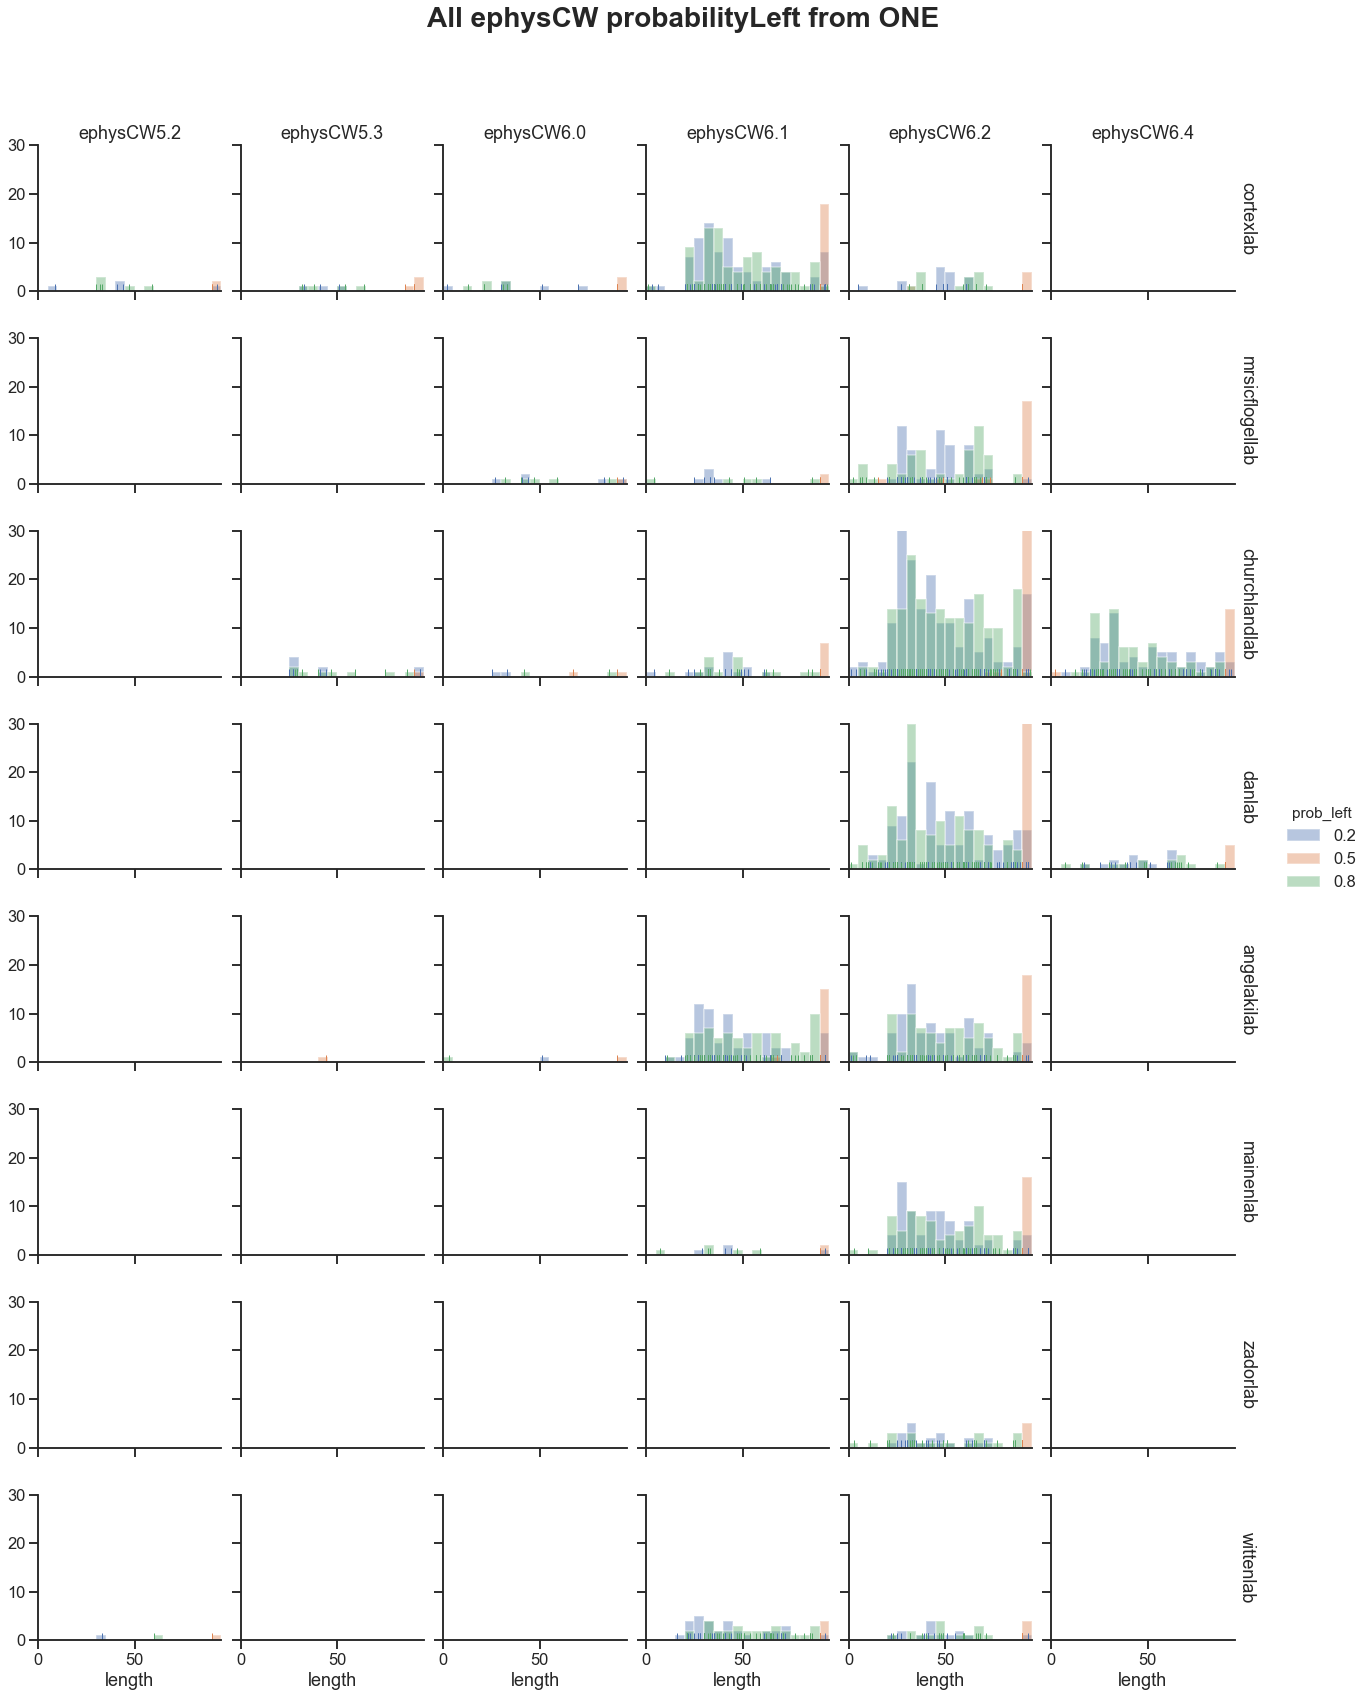

In [8]:
## make a big overview
g = sns.FacetGrid(df2, row="session_lab", col='task', 
                  col_order=sorted(df2.task.unique()), hue="prob_left", ylim=[0,30], xlim=[0,95], margin_titles=True)
g.map(sns.distplot, "length", rug=True, kde=False, hist=True, bins=np.arange(0, 100, 5)).add_legend()
[plt.setp(ax.texts, text="") for ax in g.axes.flat] # to clean margin titles on the right
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('All ephysCW probabilityLeft from ONE', fontsize=28, weight='bold')

In [9]:
# make a list of all sessions that have blocks with length 1 to patch
df2.loc[df2.length < 5, :].sort_values(by='session_start_time')

,prob_left,length,session_lab,task_protocol,session_start_time,task
2,0.8,3,angelakilab,_iblrig_tasks_ephysChoiceWorld6.0.3,2019-10-04 17:28:50,ephysCW6.0
6,0.2,2,cortexlab,_iblrig_tasks_ephysChoiceWorld6.0.3,2019-10-12 16:26:29,ephysCW6.0
4,0.2,4,churchlandlab,_iblrig_tasks_ephysChoiceWorld6.1.3,2019-11-26 14:04:09,ephysCW6.1
2,0.8,4,mrsicflogellab,_iblrig_tasks_ephysChoiceWorld6.1.3,2019-11-26 17:57:15,ephysCW6.1
11,0.8,1,cortexlab,_iblrig_tasks_ephysChoiceWorld6.1.3,2019-12-06 12:14:53,ephysCW6.1
12,0.2,3,cortexlab,_iblrig_tasks_ephysChoiceWorld6.1.3,2019-12-08 20:01:23,ephysCW6.1
3,0.8,2,mrsicflogellab,_iblrig_tasks_ephysChoiceWorld6.2.4,2019-12-10 18:32:56,ephysCW6.2
14,0.8,3,zadorlab,_iblrig_tasks_ephysChoiceWorld6.2.5,2020-01-16 15:53:22,ephysCW6.2
9,0.8,3,mainenlab,_iblrig_tasks_ephysChoiceWorld6.2.5,2020-01-21 10:44:49,ephysCW6.2
7,0.2,4,churchlandlab,_iblrig_tasks_ephysChoiceWorld6.2.5,2020-01-22 08:28:49,ephysCW6.2
